## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.datasets import fetch_lfw_people
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import skimage
from skimage import data, transform, color, feature
import warnings
warnings.filterwarnings('ignore')

In [4]:
import hw

## Load faces training data (positives)

In [3]:
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

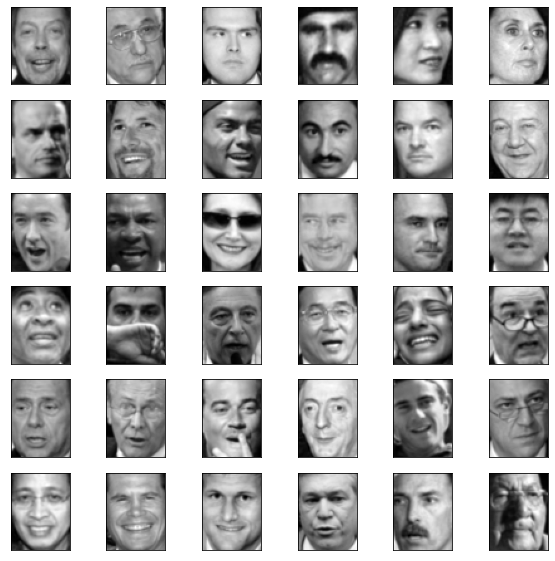

In [5]:
hw.plot_images_subset(positive_patches,
                       rows = 6,
                       columns = 6,
                       figsize= (10,10))

## Load not-faces training data (negatives)

In [14]:
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [15]:
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

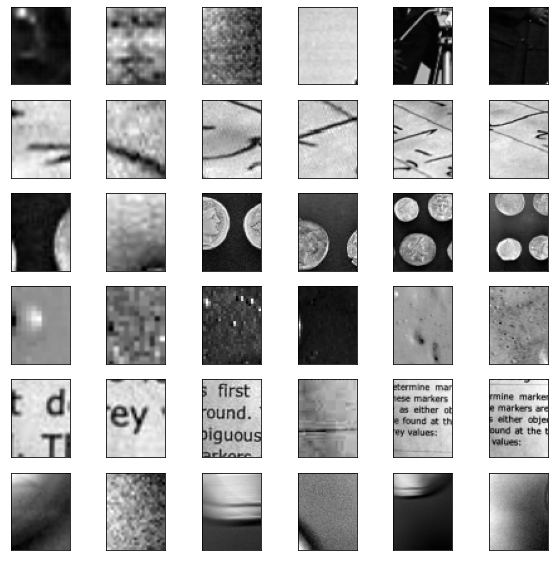

In [25]:
hw.plot_images_subset(negative_patches[::500],
                       rows = 6,
                       columns = 6,
                       figsize= (10,10))

## Visualize HOG features

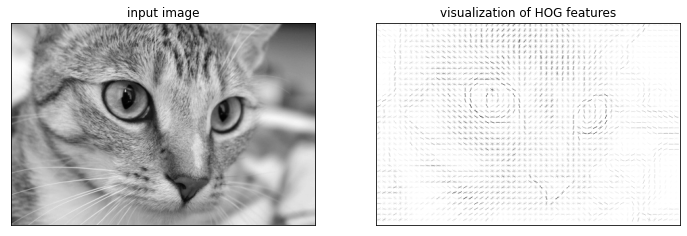

In [42]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis, cmap='gray_r')
ax[1].set_title('visualization of HOG features');

## Generate HOG training data

In [28]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

## Test Gaussian Naive Bayes with cross-validation

In [45]:
cross_val_score(GaussianNB(), X_train, y_train)

array([0.94784318, 0.97189777, 0.97236036, 0.97490169, 0.97374508])

## Test Linear SVC with cross-validation and hyperparameters

In [47]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9884347176442481

## Choose best model and fit data

In [48]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Load uncropped data

In [74]:
uncropped_data_dir = 'data/yalefaces_uncropped/yalefaces/'
images_fn = sorted(glob.glob(uncropped_data_dir+'*'))

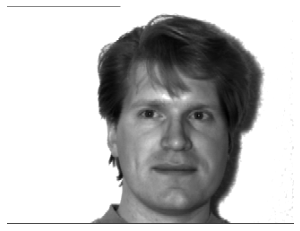

In [75]:
test_image = mpimg.imread(images_fn[0])
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off');

## Use model to detect face

In [76]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [77]:
test_image = skimage.transform.rescale(test_image,0.4)

indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

labels = model.predict(patches_hog)

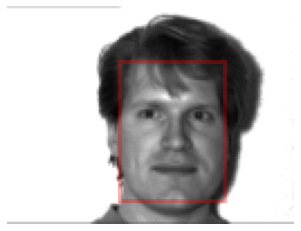

In [81]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off');

i, j = np.mean(indices[labels == 1],axis=0)

ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                           alpha=0.3, lw=4, facecolor='none'));


## Detect faces in all images and save as new cropped dataset

In [ ]:
out_dir_images = 'data/yalefaces_uncropped_cropped/images'
out_dir_qc = 'data/yalefaces_uncropped_cropped/qc'

for image_fn in images_fn:
    
    fig_out = os.path.join(out_dir_qc, os.path.split(image_fn)[-1] + '.png')
    out = os.path.join(out_dir_images, os.path.split(image_fn)[-1] + '.tif')
    test_image = mpimg.imread(image_fn)
    
    test_image = skimage.transform.rescale(test_image,0.4)
    
    indices, patches = zip(*sliding_window(test_image))
    patches_hog = np.array([feature.hog(patch) for patch in patches])
    
    labels = model.predict(patches_hog)
    
    fig, ax = plt.subplots()
    ax.imshow(test_image, cmap='gray')
    ax.axis('off')

    Ni, Nj = positive_patches[0].shape
    indices = np.array(indices)

    for i, j in indices[labels == 1]:
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                                   alpha=0.3, lw=2, facecolor='none'))
    fig.savefig(fig_out)
    plt.close(fig)
    
    i, j = np.mean(indices[labels == 1],axis=0)
    a = int(i)
    b = int(i+Ni)
    c = int(j)
    d = int(j+Nj)
    
    h = skimage.transform.rescale(test_image[a:b,c:d], 2)
    cv_image = img_as_ubyte(h)
    
    cv2.imwrite(out, cv_image)

## References

https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html